# TODO:
- write report


- (Optional) check if classification is better
- (Optional) preprocess of  product description by bullets/ removing words with number

# Practical Deep Learning Workshop 2021
## Assignment 3 - Word Embeddings
 
### Authors:
 
1.   Chen Doytshman 205644941
2.   Naor Kolet 205533060


# 0. Preliminary

## a. Imports

In [21]:
import pandas as pd
import numpy as np
 
# TensorFlow
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Concatenate
from tensorflow.keras.layers import Dropout, Dense, Lambda, Multiply, Subtract, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Activation, Reshape
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# Scikit-learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

# XGBoost
from xgboost import XGBRegressor

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Misc.
import os
import joblib
import random
import time
from tqdm import tqdm_notebook as tqdm

SEED = 42
%matplotlib inline

In [2]:
pd.set_option('display.max_colwidth', 100)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
import zipfile
DATA_DIR = 'home-depot-product-search-relevance'

files = [f for f in os.listdir(DATA_DIR) if f.endswith('zip')]
for file in tqdm(files):
    with zipfile.ZipFile(f'{DATA_DIR}/{file}') as zf:
        zf.extractall(DATA_DIR)
        os.remove(f'{DATA_DIR}/{file}')

## b. Collecting Results
throughout this notebook we are going to collect the results for the different models, on-the-fly. Later, we will discuss them in section 3 of this assignment.

In [4]:
from prettytable import PrettyTable
results = PrettyTable(['Model type', 'Runtime', 'Train RMSE',
                       'Val-RMSE', 'Test-RMSE', 'Train MAE', 
                       'Val-MAE', 'Test-MAE'], hrules=True)
results.float_format = ".4"

## c. Data Preparation, EDA

Let's load the data:

In [5]:
train_df = pd.read_csv(f'{DATA_DIR}/train.csv', index_col='id', encoding='latin-1')
product_desc_df = pd.read_csv(f'{DATA_DIR}/product_descriptions.csv', index_col='product_uid')
attributes_df = pd.read_csv(f'{DATA_DIR}/attributes.csv', index_col=['product_uid'], dtype={'product_uid': 'Int64'})

In [6]:
test_path = f'{DATA_DIR}/test_labels.csv'
if os.path.exists(test_path):
    test_df = pd.read_csv(test_path)
else:
    test_df = pd.read_csv(f'{DATA_DIR}/test.csv', index_col='id', encoding='latin-1')
    sol = pd.read_csv(f'{DATA_DIR}/solution.csv', index_col='id', encoding='latin-1')
    test_df = test_df[sol.relevance != -1]
    test_df = test_df.join(sol.relevance, on='id')
    test_df.to_csv(test_path)

In [7]:
train_df.head()

,product_uid,product_title,search_term,relevance
id,,,,
2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00
3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50
9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 Tugboat Wood and Concrete Coating,deck over,3.00
16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Kit in Chrome (Valve Not Included),rain shower head,2.33
17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Kit in Chrome (Valve Not Included),shower only faucet,2.67


In [8]:
product_counts = train_df.groupby('product_uid').count()['search_term'].value_counts()

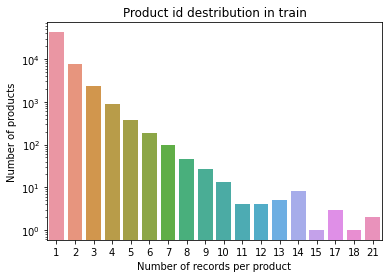

In [9]:
ax = sns.barplot(x=product_counts.index, y=product_counts.values)
ax.set_yscale('log')
ax.set_xlabel('Number of records per product')
ax.set_ylabel('Number of products')
_ = ax.set_title('Product id destribution in train')

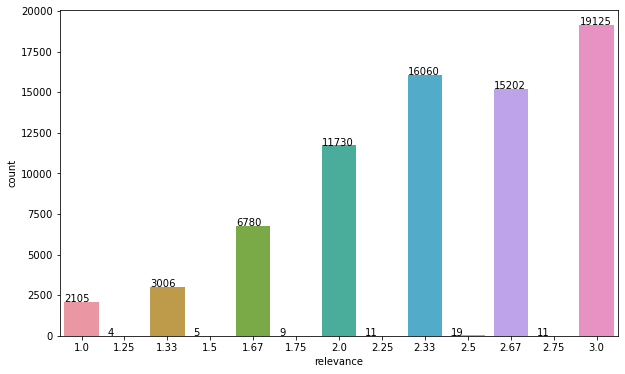

In [10]:
plt.figure(figsize=(10,6))
ax = sns.countplot(data=train_df, x="relevance")

relevance_values = train_df["relevance"].value_counts().sort_index()

for p, label in zip(ax.patches, relevance_values):
    ax.annotate(label, (p.get_x(), p.get_height()+0.5))

In [11]:
product_desc_df.head()

,product_description
product_uid,
100001,"Not only do angles make joints stronger, they also provide more consistent, straight corners. Si..."
100002,"BEHR Premium Textured DECKOVER is an innovative solid color coating. It will bring your old, wea..."
100003,"Classic architecture meets contemporary design in the Ensemble Curve series, made of solid Vikre..."
100004,The Grape Solar 265-Watt Polycrystalline PV Solar Panel bonus pack bundles 4 Grape Solar 265-Wat...
100005,Update your bathroom with the Delta Vero Single-Handle Shower Faucet Trim Kit in Chrome. It has ...


In [12]:
product_desc_df.iloc[0, 0]

'Not only do angles make joints stronger, they also provide more consistent, straight corners. Simpson Strong-Tie offers a wide variety of angles in various sizes and thicknesses to handle light-duty jobs or projects where a structural connection is needed. Some can be bent (skewed) to match the project. For outdoor projects or those where moisture is present, use our ZMAX zinc-coated connectors, which provide extra resistance against corrosion (look for a "Z" at the end of the model number).Versatile connector for various 90 connections and home repair projectsStronger than angled nailing or screw fastening aloneHelp ensure joints are consistently straight and strongDimensions: 3 in. x 3 in. x 1-1/2 in.Made from 12-Gauge steelGalvanized for extra corrosion resistanceInstall with 10d common nails or #9 x 1-1/2 in. Strong-Drive SD screws'

In [13]:
attributes_df[attributes_df.index.isin([100001])]

,name,value
product_uid,,
100001,Bullet01,Versatile connector for various 90° connections and home repair projects
100001,Bullet02,Stronger than angled nailing or screw fastening alone
100001,Bullet03,Help ensure joints are consistently straight and strong
100001,Bullet04,Dimensions: 3 in. x 3 in. x 1-1/2 in.
100001,Bullet05,Made from 12-Gauge steel
100001,Bullet06,Galvanized for extra corrosion resistance
100001,Bullet07,Install with 10d common nails or #9 x 1-1/2 in. Strong-Drive SD screws
100001,Gauge,12
100001,Material,Galvanized Steel


## d. Preprocessing

In this step we directed a few issues.

- We observed the product description and the attribute tables. We saw that all the data from the attribute table is in the product description and not all the products have records in the attribute table so we will use only the product descriptions.
- We observed that the product description have some words that got 'sticked' together, for example ```aloneHelp```, we will split those words.
- The product description does not always contain the product name so  we will concat those two.

# Space by bullets, Take long time
for p_uid, product in product_desc_df.iterrows():
    txt = product['product_description']
    
    curr_attr = attributes_df[attributes_df.index.isin([p_uid])].dropna()
    curr_attr = curr_attr[curr_attr.name.str.contains('^Bullet')]
    
    for _, attr in curr_attr.iterrows():
        ind = txt.find(attr.value[:20])
        if ind != -1:
            txt = txt[:ind] + " " + txt[ind:]
    
    product['product_description'] = txt

In [14]:
del attributes_df

In [15]:
import re
# TODO: seperate also on nubmer after chars, i.e. word100%

def striphtml(data): 
    cleanr = re.compile('<.*?>') 
    cleantext = re.sub(cleanr, ' ', data) 
    cleanr = re.compile('&nbsp;') 
    cleantext = re.sub(cleanr, ' ', cleantext) 
    return cleantext

def camel_case_split(data):
    matches = re.finditer('.+?(?:(?<=[a-z,(,)])\.?\s?(?=[A-Z])|(?<=[A-Z,(,)])\.?\s?(?=[A-Z][a-z])|$)', data)
    return ' '.join([m.group(0).strip() for m in matches])

def preprocess_description(data):
    return camel_case_split(striphtml(data))

In [16]:
product_desc_df.iloc[1,0]

'BEHR Premium Textured DECKOVER is an innovative solid color coating. It will bring your old, weathered wood or concrete back to life. The advanced 100% acrylic resin formula creates a durable coating for your tired and worn out deck, rejuvenating to a whole new look.  For the best results, be sure to properly prepare the surface using other applicable BEHR products displayed above.California residents: see&nbsp;Proposition 65 informationRevives wood and composite decks, railings, porches and boat docks, also great for concrete pool decks, patios and sidewalks100% acrylic solid color coatingResists cracking and peeling and conceals splinters and cracks up to 1/4 in.Provides a durable, mildew resistant finishCovers up to 75 sq. ft. in 2 coats per gallonCreates a textured, slip-resistant finishFor best results, prepare with the appropriate BEHR product for your wood or concrete surfaceActual paint colors may vary from on-screen and printer representationsColors available to be tinted in 

In [17]:
preprocess_description(product_desc_df.iloc[1,0])

'BEHR Premium Textured DECKOVER is an innovative solid color coating. It will bring your old, weathered wood or concrete back to life. The advanced 100% acrylic resin formula creates a durable coating for your tired and worn out deck, rejuvenating to a whole new look.  For the best results, be sure to properly prepare the surface using other applicable BEHR products displayed above. California residents: see Proposition 65 information Revives wood and composite decks, railings, porches and boat docks, also great for concrete pool decks, patios and sidewalks100% acrylic solid color coating Resists cracking and peeling and conceals splinters and cracks up to 1/4 in. Provides a durable, mildew resistant finish Covers up to 75 sq. ft. in 2 coats per gallon Creates a textured, slip-resistant finish For best results, prepare with the appropriate BEHR product for your wood or concrete surface Actual paint colors may vary from on-screen and printer representations Colors available to be tinted

In [18]:
product_desc_df['product_description'] = product_desc_df['product_description'].apply(preprocess_description)

In [19]:
def join_desc(df):
    df = df.join(product_desc_df['product_description'], on='product_uid')
    df['product_description'] = df['product_title'] + ' . ' + df['product_description']
    df['product_description'] = df['product_description'].apply(lambda x: x.replace('  ', ' '))
    df = df[['product_uid', 'search_term', 'product_description', 'relevance']]
    return df

train_df = join_desc(train_df)
test_df = join_desc(test_df)

In [20]:
train_df, val_df = train_test_split(train_df,
                                    test_size=0.2,
                                    random_state=SEED)

In [34]:
train_x = train_df[['search_term', 'product_description']]
train_y = train_df[['relevance']]

scale_y = MinMaxScaler().fit(train_y)
train_y = scale_y.transform(train_y).reshape(-1)

In [37]:
val_x = val_df[['search_term', 'product_description']]
val_y = scale_y.transform(val_df[['relevance']]).reshape(-1)
test_x = test_df[['search_term', 'product_description']]
test_y = scale_y.transform(test_df[['relevance']]).reshape(-1)

# 1. Character level LSTM

## Using character level processing to predict search relevance

### a. Preprocess the data to contain sequences of single characters

In [38]:
def tokenize_serie(serie):
    serie = pd.Series(map(lambda x: list(map(ord, list(x))), serie.values), index=serie.index)
    max_len = min(serie.apply(len).max(), 1500)
    return pad_sequences(serie, max_len, padding='post')

In [39]:
def prepare_x_char(df):
    search_term = tokenize_serie(df['search_term'])
    description = tokenize_serie(df['product_description'])
    
    search_term, description = map(lambda x: np.expand_dims(x,axis=2), [search_term, description])
    return search_term, description

In [40]:
train_x_char = prepare_x_char(train_x)
val_x_char = prepare_x_char(val_x)
test_x_char = prepare_x_char(test_x)

### b. Constructing a Siamese network

https://github.com/prabhnoor0212/Siamese-Network-Text-Similarity

#TODO: Remove extra functions

In [41]:
from tensorflow.keras import backend as K

def cosine_distance(vests):
    x, y = vests
    x = K.l2_normalize(x, axis=-1)
    y = K.l2_normalize(y, axis=-1)
    return -K.mean(x * y, axis=-1, keepdims=True)

def cos_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0],1)

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 


In [42]:
from sklearn.metrics import roc_auc_score

def auroc(y_true, y_pred):
    return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)

In [43]:
sm = 0

def common_model(length):
    global sm
    inp = Input(shape=(length, 1))
    X = Conv1D(64, 10, activation='relu')(inp)
    X = MaxPooling1D()(X)
    X = Flatten()(X)
    X = Activation('relu')(X)
    X = Dense(128, activation='relu')(X)
    
    sm += 1
    return Model(inp, X, name=f'siamese_model_{sm}')

In [44]:
common_model(128).summary()

Model: "siamese_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 119, 64)           704       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 59, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 3776)              0         
_________________________________________________________________
activation (Activation)      (None, 3776)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               483456    
Total params: 484,160
Trainable params: 484,160
Non-trainable params: 0
_____________________________________________

In [52]:
def init_siamese_model(search_term_len, product_description_len, output_shape=1):
    input_1 = Input(shape=(search_term_len, 1))
    input_2 = Input(shape=(product_description_len, 1))
    
    lstm_1 = LSTM(128)(input_1)
    lstm_2 = LSTM(128)(input_2)
    
    expand_layer = Lambda(lambda tensor: tensor[...,np.newaxis],name="expand_dim_layer")
    
    expended_1 = expand_layer(lstm_1)
    expended_2 = expand_layer(lstm_2)
    
    sm = common_model(128)

    vector_1 = sm(expended_1)
    
    vector_2 = sm(expended_2)
    
    x3 = Subtract()([vector_1, vector_2])
    x3 = Multiply()([x3, x3])

    x1_ = Multiply()([vector_1, vector_1])
    x2_ = Multiply()([vector_2, vector_2])
    x4 = Subtract()([x1_, x2_])
    
    x5 = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([vector_1, vector_2])

    conc = Concatenate(axis=-1)([x5,x4, x3])

    x = Dense(100, activation="relu")(conc)
    x = Dropout(0.01)(x)
    out = Dense(output_shape, activation="sigmoid", name = 'out')(x)

    model = Model([input_1, input_2], out)

    model.compile(loss='mse', metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')], optimizer=Adam())
    
    return model

In [53]:
init_siamese_model(train_x_char[0].shape[1],train_x_char[1].shape[1]).summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 60, 1)]      0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 1500, 1)]    0                                            
__________________________________________________________________________________________________
lstm_4 (LSTM)                   (None, 128)          66560       input_8[0][0]                    
__________________________________________________________________________________________________
lstm_5 (LSTM)                   (None, 128)          66560       input_9[0][0]                    
____________________________________________________________________________________________

#### Training framework

In [54]:
def get_callbacks(model_name):
    acc = 'val_loss'
    acc_mode = 'min'
    
    checkpoint = ModelCheckpoint(
                              fr'./models/{model_name}.h5', 
                              monitor=acc, 
#                               verbose=1, 
                              save_best_only=True, 
                              mode=acc_mode)
    earlystop = EarlyStopping(monitor=acc, mode=acc_mode, verbose=1, patience=4)
    reduceLR = ReduceLROnPlateau(monitor = 'val_loss', mode = 'min', patience = 3,
                            factor = 0.5, min_lr = 1e-6, verbose = 1)

    return [checkpoint, reduceLR, earlystop]

In [55]:
def train_model(model_gen, train_data, val_data, batch_size=128, use_saved=False):
    os.makedirs('./models', exist_ok=True)
    model_name = model_gen.__name__[5:]
        
    if use_saved:
        history = joblib.load(fr'./models/{model_name}_history.sav')
    else:
        callbacks = get_callbacks(model_name)
        
        (train_st, train_desc), train_rel = train_data
        model = model_gen(train_st.shape[1],train_desc.shape[1])
        history = model.fit(
                            x=[train_st, train_desc],
                            y=train_rel,
                            batch_size=batch_size,
                            epochs=20,
                            validation_data=val_data,
                            callbacks=callbacks
                            )
        
        history = history.history
        joblib.dump(history, fr'./models/{model_name}_history.sav')
    
    model = load_model(fr'./models/{model_name}.h5')
    
    return model, history

In [56]:
def visualize_perf(history):
    fig, ax = plt.subplots(ncols=2, figsize=(5*2,5))
    fig.suptitle(f'Model performance over epochs')
    
    for k in ['rmse', 'val_rmse']:
        ax[0].plot(history[k])
        
    ax[0].legend(['train_rmse', 'val_rmse'])
    ax[0].margins(0.01)
    ax[0].set_title('rmse')
    
    for k in ['mae', 'val_mae']:
        ax[1].plot(history[k])
        
    ax[1].legend(['train_mae', 'val_mae'])
    ax[1].margins(0.01)
    ax[1].set_title('mae')
    
    plt.show()


In [57]:
def evaluate_model(model, x, y):
    preds = model.predict(x)
    
    preds_mse = mean_squared_error(preds, y)
    preds_mae = mean_absolute_error(preds, y)
    preds_rmse = mean_squared_error(preds, y, squared=False)
    
    return preds_mse, preds_mae, preds_rmse

In [58]:
start = time.time()
char_model, char_history = train_model(init_siamese_model,
                                       (train_x_char, train_y),
                                       (val_x_char, val_y),
                                       use_saved=False)
end = time.time()

Epoch 1/20
463/463 [==============================] - 35s 75ms/step - loss: 0.0731 - mae: 0.2217 - rmse: 0.2704 - val_loss: 0.0707 - val_mae: 0.2175 - val_rmse: 0.2659 - lr: 0.0010
Epoch 2/20
463/463 [==============================] - 33s 72ms/step - loss: 0.0710 - mae: 0.2178 - rmse: 0.2664 - val_loss: 0.0701 - val_mae: 0.2158 - val_rmse: 0.2648 - lr: 0.0010
Epoch 3/20
463/463 [==============================] - 35s 75ms/step - loss: 0.0705 - mae: 0.2166 - rmse: 0.2656 - val_loss: 0.0694 - val_mae: 0.2142 - val_rmse: 0.2635 - lr: 0.0010
Epoch 4/20
463/463 [==============================] - 37s 80ms/step - loss: 0.0708 - mae: 0.2175 - rmse: 0.2661 - val_loss: 0.0709 - val_mae: 0.2178 - val_rmse: 0.2662 - lr: 0.0010
Epoch 5/20
463/463 [==============================] - 37s 80ms/step - loss: 0.0714 - mae: 0.2192 - rmse: 0.2673 - val_loss: 0.0709 - val_mae: 0.2180 - val_rmse: 0.2662 - lr: 0.0010
Epoch 6/20
463/463 [==============================] - ETA: 0s - loss: 0.0714 - mae: 0.2192 - rm

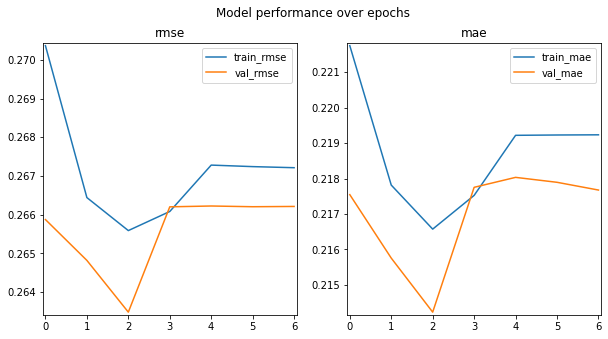

In [59]:
visualize_perf(char_history)

In [63]:
train_mse, train_mae, train_rmse =  evaluate_model(char_model, train_x_char, train_y)

print(f'MSE of {train_mse:.4f} on the train')
print(f'MAE of {train_mae:.4f} on the train')
print(f'RMSE of {train_rmse:.4f} on the train')

MSE of 0.0699 on the train
MAE of 0.2153 on the train
RMSE of 0.2643 on the train


In [64]:
val_mse, val_mae, val_rmse =  evaluate_model(char_model, val_x_char, val_y)

print(f'MSE of {val_mse:.4f} on the val')
print(f'MAE of {val_mae:.4f} on the val')
print(f'RMSE of {val_rmse:.4f} on the val')

MSE of 0.0694 on the val
MAE of 0.2142 on the val
RMSE of 0.2635 on the val


In [65]:
test_mse, test_mae, test_rmse =  evaluate_model(char_model, test_x_char, test_y)

print(f'MAE loss on test set: {test_mse:.4f}')
print(f'MSE loss on test set: {test_mse:.4f}')
print(f'RMSE loss on test set: {test_rmse:.4f}')

MAE loss on test set: 0.0704
MSE loss on test set: 0.0704
RMSE loss on test set: 0.2654


In [66]:
runtime = end - start

results.add_row(['LSTM (character level)', runtime, train_rmse, 
                 val_rmse, test_rmse, train_mae, val_mae, test_mae])

### c. Naïve model-based benchmark with ```CountVectorizer```

TODO: MARKDOWN

#### Preprocessing

In [67]:
desc_series = train_df['product_description']
search_term_series = train_df['search_term']
desc_st = pd.concat([desc_series, search_term_series])
corpus = desc_st.values
vectorizer = CountVectorizer(analyzer='char')
vectorizer.fit(corpus)
print(vectorizer.get_feature_names())

[' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '}', '~', '\x89', '\x90', '\x95', '¡', '¢', 'ª', 'à', 'ã', 'å', 'è', 'ê', 'ò', '÷', 'û', 'ü']


In [68]:
def prepare_x_naive(df):
    desc_series = df['product_description']
    search_term_series = df['search_term']
    counts_desc = vectorizer.transform(desc_series).toarray()
    counts_st = vectorizer.transform(search_term_series).toarray()
    X = np.concatenate([counts_desc, counts_st], axis=1)
    return X

In [69]:
train_x_charvec  = prepare_x_naive(train_x)
val_x_charvec = prepare_x_naive(val_x)
test_x_charvec = prepare_x_naive(test_x)

In [70]:
use_saved = False
rfr_path = 'models/rfr.sav'

if use_saved:
    rfr = joblib.load(rfr_path)
else:
    rfr = RandomForestRegressor(random_state=SEED, verbose=0, n_jobs=-1)
    start = time.time()
    rfr.fit(train_x_charvec, train_y)
    end = time.time()
    joblib.dump(rfr, rfr_path)

In [71]:
train_mse, train_mae, train_rmse =  evaluate_model(rfr, train_x_charvec, train_y)

print(f'Got MSE of {train_mse:.4f} on the train')
print(f'Got MAE of {train_mae:.4f} on the train')
print(f'Got RMSE of {train_rmse:.4f} on the train')

Got MSE of 0.0088 on the train
Got MAE of 0.0754 on the train
Got RMSE of 0.0937 on the train


In [72]:
val_mse, val_mae, val_rmse =  evaluate_model(rfr, val_x_charvec, val_y)

print(f'Got MSE of {val_mse:.4f} on the val')
print(f'Got MAE of {val_mae:.4f} on the val')
print(f'Got RMSE of {val_rmse:.4f} on the val')

Got MSE of 0.0611 on the val
Got MAE of 0.2011 on the val
Got RMSE of 0.2473 on the val


In [73]:
test_mse, test_mae, test_rmse =  evaluate_model(rfr, test_x_charvec, test_y)

print(f'Got MSE of {test_mse:.4f} on the test')
print(f'Got MAE of {test_mae:.4f} on the test')
print(f'Got RMSE of {test_rmse:.4f} on the test')

Got MSE of 0.0684 on the test
Got MAE of 0.2138 on the test
Got RMSE of 0.2615 on the test


In [74]:
runtime = end - start

results.add_row(['Naïve benchmark (section 1c)', runtime, train_rmse, 
                 val_rmse, test_rmse, train_mae, val_mae, test_mae])

### d. Using our model as a feature extractor

In [75]:
fe_char_model = Model(char_model.input, char_model.layers[-3].output)

In [76]:
train_features = fe_char_model.predict(train_x_char)
val_features = fe_char_model.predict(val_x_char)
test_features = fe_char_model.predict(test_x_char)

In [77]:
use_saved = False

fe_rfr_path = 'models/fe_char_rfr.sav'
fe_xgb_path = 'models/fe_char_xgb.sav'

if use_saved:
    rfr_model = joblib.load(fe_rfr_path)
    xgb_model = joblib.load(fe_xgb_path)
else:
    xgb_model = XGBRegressor(use_label_encoder=False, n_jobs=-1)
    rfr_model = RandomForestRegressor(random_state=SEED, verbose=0, n_jobs=-1)

    print('training xgb')
    start_xgb = time.time()
    xgb_model.fit(train_features, train_y)
    end_xgb = time.time()
    print('training rfr')
    start_rfr = time.time()
    rfr_model.fit(train_features, train_y)
    end_rfr = time.time()

    joblib.dump(rfr_model, fe_rfr_path)
    joblib.dump(xgb_model, fe_xgb_path)

training xgb
training rfr


#### Evaluating RandomForest

In [78]:
train_mse, train_mae, train_rmse =  evaluate_model(rfr_model, train_features, train_y)

print(f'Got MSE of {train_mse:.4f} on the train')
print(f'Got MAE of {train_mae:.4f} on the train')
print(f'Got RMSE of {train_rmse:.4f} on the train')

Got MSE of 0.0296 on the train
Got MAE of 0.1307 on the train
Got RMSE of 0.1720 on the train


In [79]:
val_mse, val_mae, val_rmse =  evaluate_model(rfr_model, val_features, val_y)

print(f'Got MSE of {val_mse:.4f} on the val')
print(f'Got MAE of {val_mae:.4f} on the val')
print(f'Got RMSE of {val_rmse:.4f} on the val')

Got MSE of 0.0628 on the val
Got MAE of 0.1975 on the val
Got RMSE of 0.2507 on the val


In [80]:
test_mse, test_mae, test_rmse =  evaluate_model(rfr_model, test_features, test_y)

print(f'Got MSE of {test_mse:.4f} on the test')
print(f'Got MAE of {test_mae:.4f} on the test')
print(f'Got RMSE of {test_rmse:.4f} on the test')

Got MSE of 0.0819 on the test
Got MAE of 0.2297 on the test
Got RMSE of 0.2862 on the test


In [81]:
runtime = end_rfr - start_rfr

results.add_row(['Random Forest (character LSTM Features)', runtime, train_rmse, 
                 val_rmse, test_rmse, train_mae, val_mae, test_mae])

#### Evaluating XGBoost

In [82]:
train_mse, train_mae, train_rmse =  evaluate_model(xgb_model, train_features, train_y)

print(f'Got MSE of {train_mse:.4f} on the train')
print(f'Got MAE of {train_mae:.4f} on the train')
print(f'Got RMSE of {train_rmse:.4f} on the train')

Got MSE of 0.0582 on the train
Got MAE of 0.1965 on the train
Got RMSE of 0.2413 on the train


In [83]:
val_mse, val_mae, val_rmse =  evaluate_model(xgb_model, val_features, val_y)

print(f'Got MSE of {val_mse:.4f} on the val')
print(f'Got MAE of {val_mae:.4f} on the val')
print(f'Got RMSE of {val_rmse:.4f} on the val')

Got MSE of 0.0655 on the val
Got MAE of 0.2088 on the val
Got RMSE of 0.2559 on the val


In [84]:
test_mse, test_mae, test_rmse =  evaluate_model(xgb_model, test_features, test_y)

print(f'Got MSE of {test_mse:.4f} on the test')
print(f'Got MAE of {test_mae:.4f} on the test')
print(f'Got RMSE of {test_rmse:.4f} on the test')

Got MSE of 0.0711 on the test
Got MAE of 0.2178 on the test
Got RMSE of 0.2667 on the test


In [85]:
runtime = end_xgb - start_xgb

results.add_row(['XGBoost (character LSTM Features)', runtime, train_rmse, 
                 val_rmse, test_rmse, train_mae, val_mae, test_mae])

# 2. Word embeddings and word level LSTM

## Using word/character-combination level processing to predict search relevance

### a. Preprocess the data to create tokens of words/character-combinations

In [86]:
desc_series = train_x['product_description']
search_term_series = train_x['search_term']
desc_st = pd.concat([desc_series, search_term_series])

In [103]:
def tokenize_words(serie):
    serie = pd.Series(tokenizer.texts_to_sequences(serie.values), index=serie.index)
    max_len = 1051
    return pad_sequences(serie, max_len, padding='post')

In [104]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(desc_st)

In [105]:
train_desc_padded = tokenize_words(train_df['product_description'])
train_st_padded = tokenize_words(train_df['search_term'])

In [106]:
val_desc_padded = tokenize_words(val_df['product_description'])
val_st_padded = tokenize_words(val_df['search_term'])

In [107]:
test_desc_padded = tokenize_words(test_df['product_description'])
test_st_padded = tokenize_words(test_df['search_term'])

### b. Create embeddings

In [93]:
EMBEDDING_FILE = './GoogleNews-vectors-negative300.bin'

if not os.path.isfile(EMBEDDING_FILE):
    !wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

In [94]:
!gzip -f -d GoogleNews-vectors-negative300.bin.gz

gzip: GoogleNews-vectors-negative300.bin.gz: No such file or directory


In [111]:
from gensim import models

embeddings_index = models.KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)
embed_size = 300
word_index = tokenizer.word_index
max_features = len(word_index) + 1

nb_words = min(len(word_index), len(word_index))
embedding_matrix = (np.random.rand(nb_words+1, embed_size) - 0.5) / 5.0
for word, i in word_index.items():
    if i >= max_features: continue
    if word in embeddings_index:
        embedding_vector = embeddings_index.get_vector(word)
        embedding_matrix[i] = embedding_vector

### c. Constructing a Siamese network

In [112]:
def init_siamese_model_words(search_term_len, product_description_len, output_shape=1):
    input_1 = Input(shape=(search_term_len,))
    input_2 = Input(shape=(product_description_len,))
    
    embd1 = Embedding(max_features, 
                      embed_size, 
                      weights=[embedding_matrix],
                      input_length=search_term_len,
                      name='search_embd')(input_1)
    
    embd2 = Embedding(max_features,
                      embed_size,
                      weights=[embedding_matrix],
                      input_length=product_description_len,
                      name='desc_embd')(input_2)
    
    lstm_1 = LSTM(128)(embd1)
    lstm_2 = LSTM(128)(embd2)
    
    expand_layer = Lambda(lambda tensor: tensor[...,np.newaxis],name="expand_dim_layer")
    
    expended_1 = expand_layer(lstm_1)
    expended_2 = expand_layer(lstm_2)
    
    sm = common_model(128)

    vector_1 = sm(expended_1)
    
    vector_2 = sm(expended_2)
    
    x3 = Subtract()([vector_1, vector_2])
    x3 = Multiply()([x3, x3])

    x1_ = Multiply()([vector_1, vector_1])
    x2_ = Multiply()([vector_2, vector_2])
    x4 = Subtract()([x1_, x2_])
    
    x5 = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([vector_1, vector_2])

    conc = Concatenate(axis=-1)([x5,x4, x3])

    x = Dense(100, activation="relu")(conc)
    x = Dropout(0.01)(x)
    out = Dense(output_shape, activation="sigmoid", name = 'out')(x)

    model = Model([input_1, input_2], out)
    
    model.get_layer('search_embd').trainable = False
    model.get_layer('desc_embd').trainable = False

    model.compile(loss='mse', metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')], optimizer=Adam())
    
    return model

In [113]:
init_siamese_model_words(train_st_padded.shape[1],train_desc_padded.shape[1]).summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, 1051)]       0                                            
__________________________________________________________________________________________________
input_21 (InputLayer)           [(None, 1051)]       0                                            
__________________________________________________________________________________________________
search_embd (Embedding)         (None, 1051, 300)    18744300    input_20[0][0]                   
__________________________________________________________________________________________________
desc_embd (Embedding)           (None, 1051, 300)    18744300    input_21[0][0]                   
____________________________________________________________________________________________

In [114]:
train_data = ((train_st_padded, train_desc_padded), train_y)
val_data = ((val_st_padded, val_desc_padded), val_y)
start = time.time()
word_model, word_history = train_model(init_siamese_model_words, train_data, val_data, use_saved=False)
end = time.time()

Epoch 1/20
463/463 [==============================] - 84s 182ms/step - loss: 0.0727 - mae: 0.2213 - rmse: 0.2697 - val_loss: 0.0710 - val_mae: 0.2171 - val_rmse: 0.2664 - lr: 0.0010
Epoch 2/20
463/463 [==============================] - 84s 181ms/step - loss: 0.0716 - mae: 0.2192 - rmse: 0.2675 - val_loss: 0.0710 - val_mae: 0.2185 - val_rmse: 0.2664 - lr: 0.0010
Epoch 3/20
463/463 [==============================] - 84s 181ms/step - loss: 0.0715 - mae: 0.2192 - rmse: 0.2674 - val_loss: 0.0709 - val_mae: 0.2172 - val_rmse: 0.2664 - lr: 0.0010
Epoch 4/20
463/463 [==============================] - 84s 181ms/step - loss: 0.0714 - mae: 0.2192 - rmse: 0.2673 - val_loss: 0.0709 - val_mae: 0.2179 - val_rmse: 0.2662 - lr: 0.0010
Epoch 5/20
463/463 [==============================] - 82s 176ms/step - loss: 0.0715 - mae: 0.2192 - rmse: 0.2673 - val_loss: 0.0709 - val_mae: 0.2181 - val_rmse: 0.2662 - lr: 0.0010
Epoch 6/20
463/463 [==============================] - 86s 186ms/step - loss: 0.0714 - mae:

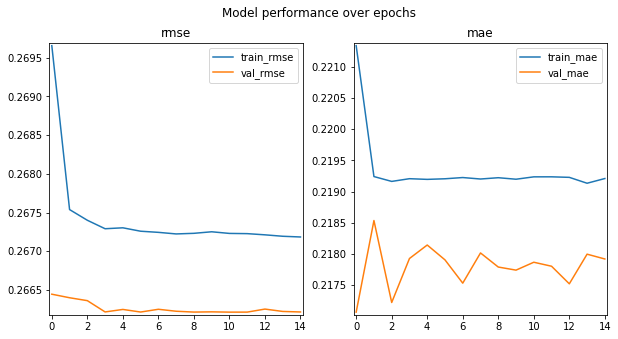

In [115]:
visualize_perf(word_history)

In [116]:
train_mse, train_mae, train_rmse = evaluate_model(word_model, [train_st_padded, train_desc_padded], train_y)

print(f'Got MSE of {train_mse:.4f} on the train')
print(f'Got MAE of {train_mae:.4f} on the train')
print(f'Got RMSE of {train_rmse:.4f} on the train')

Got MSE of 0.0714 on the train
Got MAE of 0.2193 on the train
Got RMSE of 0.2672 on the train


In [117]:
val_mse, val_mae, val_rmse = evaluate_model(word_model, [val_st_padded, val_desc_padded], val_y)

print(f'Got MSE of {val_mse:.4f} on the val')
print(f'Got MAE of {val_mae:.4f} on the val')
print(f'Got RMSE of {val_rmse:.4f} on the val')

Got MSE of 0.0709 on the val
Got MAE of 0.2179 on the val
Got RMSE of 0.2662 on the val


In [118]:
test_mse, test_mae, test_rmse = evaluate_model(word_model, [test_st_padded, test_desc_padded], test_y)

print(f'Got MSE of {test_mse:.4f} on the test')
print(f'Got MAE of {test_mae:.4f} on the test')
print(f'Got RMSE of {test_rmse:.4f} on the test')

Got MSE of 0.0716 on the test
Got MAE of 0.2194 on the test
Got RMSE of 0.2676 on the test


In [119]:
runtime = end - start

results.add_row(['LSTM (word level)', runtime, train_rmse, 
                 val_rmse, test_rmse, train_mae, val_mae, test_mae])

### d. Using our model as a feature extractor

In [120]:
fe_word_model = Model(word_model.input, word_model.layers[-3].output)

In [121]:
train_features = fe_word_model.predict([train_st_padded, train_desc_padded])
val_features = fe_word_model.predict([val_st_padded, val_desc_padded])
test_features = fe_word_model.predict([test_desc_padded, test_st_padded])

In [122]:
use_saved = False

fe_rfr_path = 'models/fe_word_rfr.sav'
fe_xgb_path = 'models/fe_word_xgb.sav'

if use_saved:
    rfr_model = joblib.load(fe_rfr_path)
    xgb_model = joblib.load(fe_xgb_path)
else:
    xgb_model = XGBRegressor(use_label_encoder=False, n_jobs=-1)
    rfr_model = RandomForestRegressor(random_state=SEED, verbose=0, n_jobs=-1)

    print('training xgb')
    start_xgb = time.time()
    xgb_model.fit(train_features, train_y)
    end_xgb = time.time()
    print('training rfr')
    start_rfr = time.time()
    rfr_model.fit(train_features, train_y)
    end_rfr = time.time()

    joblib.dump(rfr_model, fe_rfr_path)
    joblib.dump(xgb_model, fe_xgb_path)

training xgb
training rfr


#### Evaluating RandomForest

In [123]:
train_features = fe_word_model.predict([train_st_padded, train_desc_padded])
val_features = fe_word_model.predict([val_st_padded, val_desc_padded])
test_features = fe_word_model.predict([test_desc_padded, test_st_padded])

In [124]:
train_mse, train_mae, train_rmse = evaluate_model(rfr_model, train_features, train_y)

print(f'Got MSE of {train_mse:.4f} on the train')
print(f'Got MAE of {train_mae:.4f} on the train')
print(f'Got RMSE of {train_rmse:.4f} on the train')

Got MSE of 0.0714 on the train
Got MAE of 0.2192 on the train
Got RMSE of 0.2672 on the train


In [125]:
val_mse, val_mae, val_rmse = evaluate_model(rfr_model, val_features, val_y)

print(f'Got MSE of {val_mse:.4f} on the val')
print(f'Got MAE of {val_mae:.4f} on the val')
print(f'Got RMSE of {val_rmse:.4f} on the val')

Got MSE of 0.0709 on the val
Got MAE of 0.2178 on the val
Got RMSE of 0.2662 on the val


In [126]:
test_mse, test_mae, test_rmse = evaluate_model(rfr_model, test_features, test_y)

print(f'Got MSE of {test_mse:.4f} on the test')
print(f'Got MAE of {test_mae:.4f} on the test')
print(f'Got RMSE of {test_rmse:.4f} on the test')

Got MSE of 0.0716 on the test
Got MAE of 0.2193 on the test
Got RMSE of 0.2676 on the test


In [127]:
runtime = end_rfr - start_rfr

results.add_row(['Random Forest (word LSTM Features)', runtime, train_rmse, 
                 val_rmse, test_rmse, train_mae, val_mae, test_mae])

#### Evaluating XGBoost

In [128]:
train_mse, train_mae, train_rmse = evaluate_model(xgb_model, train_features, train_y)

print(f'Got MSE of {train_mse:.4f} on the train')
print(f'Got MAE of {train_mae:.4f} on the train')
print(f'Got RMSE of {train_rmse:.4f} on the train')

Got MSE of 0.0708 on the train
Got MAE of 0.2180 on the train
Got RMSE of 0.2661 on the train


In [129]:
val_mse, val_mae, val_rmse = evaluate_model(xgb_model, val_features, val_y)

print(f'Got MSE of {val_mse:.4f} on the val')
print(f'Got MAE of {val_mae:.4f} on the val')
print(f'Got RMSE of {val_rmse:.4f} on the val')

Got MSE of 0.0712 on the val
Got MAE of 0.2181 on the val
Got RMSE of 0.2668 on the val


In [130]:
test_mse, test_mae, test_rmse = evaluate_model(xgb_model, test_features, test_y)

print(f'Got MSE of {test_mse:.4f} on the test')
print(f'Got MAE of {test_mae:.4f} on the test')
print(f'Got RMSE of {test_rmse:.4f} on the test')

Got MSE of 0.0720 on the test
Got MAE of 0.2196 on the test
Got RMSE of 0.2684 on the test


In [131]:
runtime = end_xgb - start_xgb

results.add_row(['XGBoost (word LSTM Features)', runtime, train_rmse, 
                 val_rmse, test_rmse, train_mae, val_mae, test_mae])

# 3. Comparison of Results

Let's now review the results we've collected thorughout this assignment and discuss them.

In [132]:
print(results)

+-----------------------------------------+-----------+------------+----------+-----------+-----------+---------+----------+
|                Model type               |  Runtime  | Train RMSE | Val-RMSE | Test-RMSE | Train MAE | Val-MAE | Test-MAE |
+-----------------------------------------+-----------+------------+----------+-----------+-----------+---------+----------+
|          LSTM (character level)         |  257.0069 |   0.2643   |  0.2635  |   0.2654  |   0.2153  |  0.2142 |  0.2158  |
+-----------------------------------------+-----------+------------+----------+-----------+-----------+---------+----------+
|       Naïve benchmark (section 1c)      |  64.6946  |   0.0937   |  0.2473  |   0.2615  |   0.0754  |  0.2011 |  0.2138  |
+-----------------------------------------+-----------+------------+----------+-----------+-----------+---------+----------+
| Random Forest (character LSTM Features) |  171.5378 |   0.1720   |  0.2507  |   0.2862  |   0.1307  |  0.1975 |  0.2297  |


In [160]:
def plot_compare(hs, tvs, names):
    epochs = len(hs[0]['rmse'])
    for h in hs[1:]:
        epochs = max(epochs, len(h['rmse']))
    for h in hs:
        dif = epochs - len(h['rmse'])
        if dif:
            for k in h:
                h[k] = h[k] + h[k][-1:]*dif
    
    fig, ax = plt.subplots(ncols=4, figsize=(4*4,8))
    symbols = [None]*len(names)
    i = 0
    
    for h in hs:
        symbols[i] = ax[0].plot(h['rmse'])[0]
        ax[1].plot(h['mae'])
        ax[2].plot(h['val_rmse'])
        ax[3].plot(h['val_mae'])
        i+=1
        
    for tv in tvs:
        symbols[i] = ax[0].plot([tv[0]]*epochs)[0]
        ax[1].plot([tv[1]]*epochs)
        ax[2].plot([tv[2]]*epochs)
        ax[3].plot([tv[3]]*epochs)
        i+=1
        
    ax[0].set_title('train_rmse')
    ax[1].set_title('train_mae')
    ax[2].set_title('val_rmse')
    ax[3].set_title('val_mae')

    
    fig.legend(symbols, names, bbox_to_anchor=(0.3, 1.1))

In [161]:
import json
dicts = json.loads(results.get_json_string())[2:]
dicts = [d for d in dicts if d != 'LSTM (word level)']

histories = [char_history, word_history]
train_vals = [(d['Train RMSE'], d['Train MAE'], d['Val-RMSE'], d['Val-MAE']) for d in dicts]
names = ['LSTM (character level)', 'LSTM (word level)'] + [d['Model type'] for d in dicts]

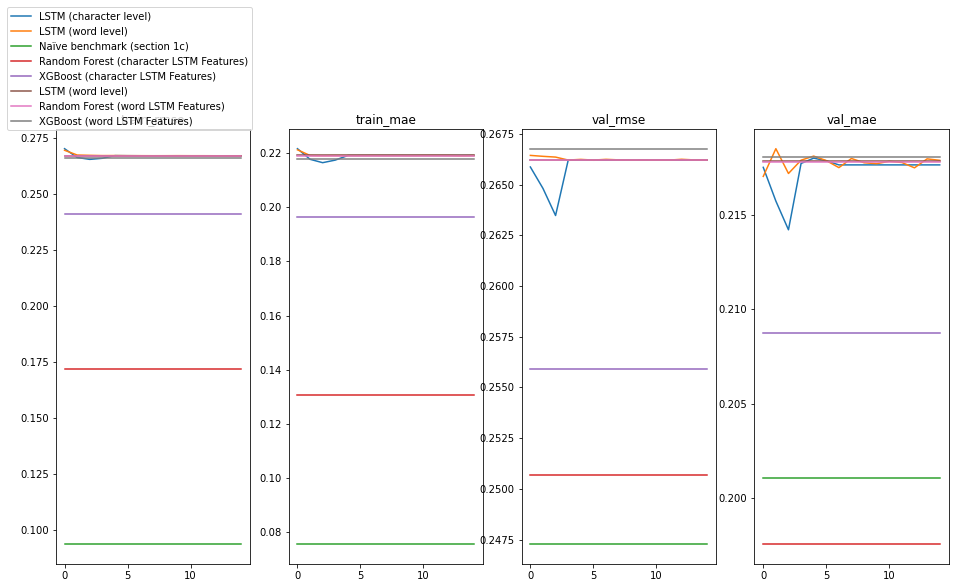

In [162]:
plot_compare(histories, train_vals, names)

# 4. Final Report